In [2]:
%matplotlib inline
%load_ext autoreload
%config InlineBackend.figure_format = 'retina' # high res plotting
import numpy as np
import scipy
import matplotlib.pyplot as plt
import IPython.display as ipd
import sys
# import os 
# import h5py

In [3]:

import pycircstat

In [4]:
# Import Seaborn

import seaborn as sns
# sns.set_style('whitegrid')

In [5]:
import matplotlib
# plot settings
# font = {'family' : 'Bitstream Vera Sans',
#         'weight' : 'regular',
#         'size'   : 13}
font = {'weight' : 'regular',
        'size'   : 13}
figure = {'figsize' : (20,8)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)

In [6]:
%autoreload 2
# import BirdSongToolbox.GetBirdData as gbd
# import BirdSongToolbox.file_utility_functions as fuf
# import BirdSongToolbox.Epoch_Analysis_Tools as bep
# import BirdSongToolbox as tb
# from BirdSongToolbox.file_utility_functions import _load_pckl_data #, _load_numpy_data, _load_json_data
import BirdSongToolbox.free_epoch_tools as fet
import BirdSongToolbox.preprocess as pp

from BirdSongToolbox.import_data import ImportData
from BirdSongToolbox.context_hand_labeling import ContextLabels
from BirdSongToolbox.context_hand_labeling import label_focus_context, first_context_func, last_context_func, mid_context_func
from BirdSongToolbox.behave.behave_utils import event_array_maker_chunk, get_events_rasters, repeat_events


In [7]:
#file structure for /src
package_folder = '/home/debrown/Songbird-LFP-Paper/'
sys.path.append(package_folder)

In [8]:
%autoreload 2
import src.analysis.hilbert_based_pipeline as hbp

from src.utils.paths import FIGURES_DIR

from src.visualization.time_series_vis import plot_pretty_ersp

import src.analysis.ml_pipeline_utilities as mlpu

# This should be moved to a visualization specific module
from src.analysis.chunk_spectral_perturbation_report import plot_behavior_test
from src.analysis.context_utility import birds_context_obj

In [9]:
# Select bird_id and session
bird_id = 'z007'
session =  'day-2016-09-11'
# 'day-2016-09-11'

In [10]:
zdata = ImportData(bird_id=bird_id, session=session)


# Get the Handlables

In [11]:
chunk_labels_list, chunk_onsets_list = fet.get_chunk_handlabels(handlabels_list=zdata.song_handlabels)

# Pre-Process The Data to get the Normalized Power Values

In [12]:
# fc_lo = np.arange(3, 249, 2)
# fc_hi = np.arange(5, 251, 2)

In [13]:
# Switch to the Log Spaced Bins
freq_bins = 100
fc_lo = np.logspace(np.log10(2), np.log10(220), freq_bins)
fc_hi = np.logspace(np.log10(3), np.log10(250), freq_bins)

In [14]:
proc_data = hbp.itc_phase_chunk(neural_chunks=zdata.song_neural, 
                                        fs=1000, 
                                        l_freqs=fc_lo, 
                                        h_freqs=fc_hi, 
                                        verbose=True)

On Chunk # 0
CAR Done
Filters Done
Hilbert Done
On Chunk # 1
CAR Done
Filters Done
Hilbert Done
On Chunk # 2
CAR Done
Filters Done
Hilbert Done
On Chunk # 3
CAR Done
Filters Done
Hilbert Done
On Chunk # 4
CAR Done
Filters Done
Hilbert Done
On Chunk # 5
CAR Done
Filters Done
Hilbert Done
On Chunk # 6
CAR Done
Filters Done
Hilbert Done
On Chunk # 7
CAR Done
Filters Done
Hilbert Done
On Chunk # 8
CAR Done
Filters Done
Hilbert Done
On Chunk # 9
CAR Done
Filters Done
Hilbert Done
On Chunk # 10
CAR Done
Filters Done
Hilbert Done
On Chunk # 11
CAR Done
Filters Done
Hilbert Done
On Chunk # 12
CAR Done
Filters Done
Hilbert Done
On Chunk # 13
CAR Done
Filters Done
Hilbert Done
On Chunk # 14
CAR Done
Filters Done
Hilbert Done
On Chunk # 15
CAR Done
Filters Done
Hilbert Done
On Chunk # 16
CAR Done
Filters Done
Hilbert Done
On Chunk # 17
CAR Done
Filters Done
Hilbert Done
On Chunk # 18
CAR Done
Filters Done
Hilbert Done
On Chunk # 19
CAR Done
Filters Done
Hilbert Done


# Get the Start Times of the Events of Interest

In [15]:
# Helper Function to create the properly initialized context class
testclass = birds_context_obj(bird_id= bird_id)

In [16]:
# Get the Context Array for the Day's Data

test_context = testclass.get_all_context_index_arrays(chunk_labels_list)

In [17]:
# Select Labels Using Flexible Context Selection
first_syll = label_focus_context(focus=1, 
                                      labels=chunk_labels_list, 
                                      starts= chunk_onsets_list[0], 
                                      contexts= test_context, 
                                      context_func=first_context_func)

last_syll = label_focus_context(focus=5, 
                                labels=chunk_labels_list, 
                                starts= chunk_onsets_list[1], 
                                contexts= test_context, 
                                context_func=last_context_func)


# Get the Event alligned Values of Interest Using

In [18]:
# Set the Context Windows

first_window = (-500, 800)
last_window = (-800, 300)

In [19]:
# Remove Outlier Motifs for the Visualization:

first_rm = [6, 13, 14, 15, 16, 20, 31, 7, 8, 36] # Last 3 are from code glitch
last_rm = [6, 11, 13, 17, 19, 20, 21, 33]

In [20]:
# Clip around Events of Interest
all_firsts = fet.get_event_related_nd_chunk(chunk_data=proc_data, chunk_indices=first_syll, 
                                        fs=1000, window=first_window )

all_lasts = fet.get_event_related_nd_chunk(chunk_data=proc_data, chunk_indices=last_syll, 
                                        fs=1000, window=last_window )


In [21]:
# Correct The Shape of the Data

all_firsts = fet.event_shape_correction(all_firsts, original_dim=3)

all_lasts = fet.event_shape_correction(all_lasts, original_dim=3)

In [22]:
np.shape(all_firsts)

all_firsts = np.delete(all_firsts, first_rm, axis = 0)
all_lasts = np.delete(all_lasts, last_rm, axis = 0)

# Calculate The Vector and Z-Score

In [23]:
# Create the Event Times 

first_event_times = fet.make_event_times_axis(first_window, fs=1000)

last_event_times = fet.make_event_times_axis(last_window, fs=1000)

In [24]:
def plot_itc(ersp, event_times, fc_lo, fc_hi,   cmap=None, **kwargs):
    """

    :param cmap:
    :param ersp:
    :param event_times:
    :param kwargs: Check the Seaborn Options (Lots of control here)
    :return:
    """

    if cmap is None:
        cmap = 'RdBu_r'

    ax = sns.heatmap(ersp, xticklabels=event_times, yticklabels=(fc_lo + fc_hi) / 2, cmap=cmap, **kwargs)

    ax.invert_yaxis()
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 100 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
    for ind, label in enumerate(ax.get_yticklabels()):
        if ind % 5 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
    if ax is None:
        plt.show()

In [25]:
first_itc = pycircstat.resultant_vector_length(np.asarray(all_firsts), axis=0)
first_itc_p, first_itc_z = pycircstat.rayleigh(np.asarray(all_firsts), axis=0)

In [27]:
last_itc = pycircstat.resultant_vector_length(np.asarray(all_lasts), axis=0)
last_itc_p, last_itc_z = pycircstat.rayleigh(np.asarray(all_lasts), axis=0)

In [28]:
print(np.shape(first_itc))
print(np.shape(last_itc))

(100, 32, 1300)
(100, 32, 1100)


In [29]:
# Create the Event Times 

first_event_times = fet.make_event_times_axis(first_window, fs=1000)
last_event_times = fet.make_event_times_axis(last_window, fs=1000)

## Make the Event Raster Plot (To Show Behavior Above Activity)

In [30]:
# Create timeseries representing the labeled Events For all Chunks

event_array_test2 = event_array_maker_chunk(labels_list=chunk_labels_list, 
                                        onsets_list=chunk_onsets_list)

In [31]:
# Make Behavior Raster for First 
first_events2 = get_events_rasters(data= event_array_test2, indices= first_syll, fs=1000, window=first_window)
first_events = np.delete(first_events2, first_rm, axis = 0)
fill_events_first = repeat_events(first_events)

# Make Behavior Raster for Last 
last_events2 = get_events_rasters(data= event_array_test2, indices= last_syll, fs=1000, window=last_window)
last_events = np.delete(last_events2, last_rm, axis = 0)

fill_events_last = repeat_events(last_events)

In [32]:
# TODO: Clean-up and Document this Visualization Function

def plot_behavior_test2(fill_events_context, context_event_times, context_events, show_x = False, ax=None):
    # Setup the Colorbar
    cmap2 = matplotlib.colors.ListedColormap(
        ['black', 'red', 'orange', 'yellow', 'saddlebrown', 'blue', 'green', 'white', 'pink', 'purple'])
    cmap2.set_over('cyan')
    cmap2.set_under('cyan')
    bounds = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N)

    # PlotBehavior Raster
    num_events = context_events.shape[0]
    max_len = fill_events_context.shape[0]
    bin_width = max_len / num_events
    y_labels = np.arange(0, num_events, 5, dtype=int)
    y_steps = np.linspace(0, y_labels[-1] * bin_width, len(y_labels), dtype=int)
    y_steps[1:] = y_steps[1:] - int(bin_width / 2)

    if ax is None:
        plt.imshow(fill_events_context, cmap=cmap2, Norm=norm, aspect="auto")
        plt.yticks(ticks=y_steps[1:], labels=y_labels[1:])
        plt.ylim(0, max_len)
        ax = plt.gca() # Get the Current Axis

    else:
        ax.imshow(fill_events_context, cmap=cmap2, Norm=norm, aspect="auto")
        ax.set_yticks(y_steps[1:])
        ax.set_yticklabels(y_labels[1:])
        ax.set_ylim(0, max_len)
    
    if show_x:
        ax.set_xticks(np.arange(len(context_event_times)))
        ax.set_xticklabels(context_event_times)
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

        visible_xticks = []
        visible_xtickslabels = []
        for ind, label in enumerate(ax.get_xticklabels()):
            if ind % 100 == 0:
                visible_xticks.append(ind)
                visible_xtickslabels.append(label)
        ax.set_xticks(visible_xticks)
        ax.set_xticklabels(visible_xtickslabels)
    else:
        ax.set_xticks([])
        
        
    
    

In [33]:
np.shape(first_events)

(27, 1300)

In [39]:
# plot_behavior_test2(fill_events_context=fill_events_first,
#                    context_event_times=first_event_times,  
#                    context_events=first_events, 
#                     show_x=True,  ax = None)

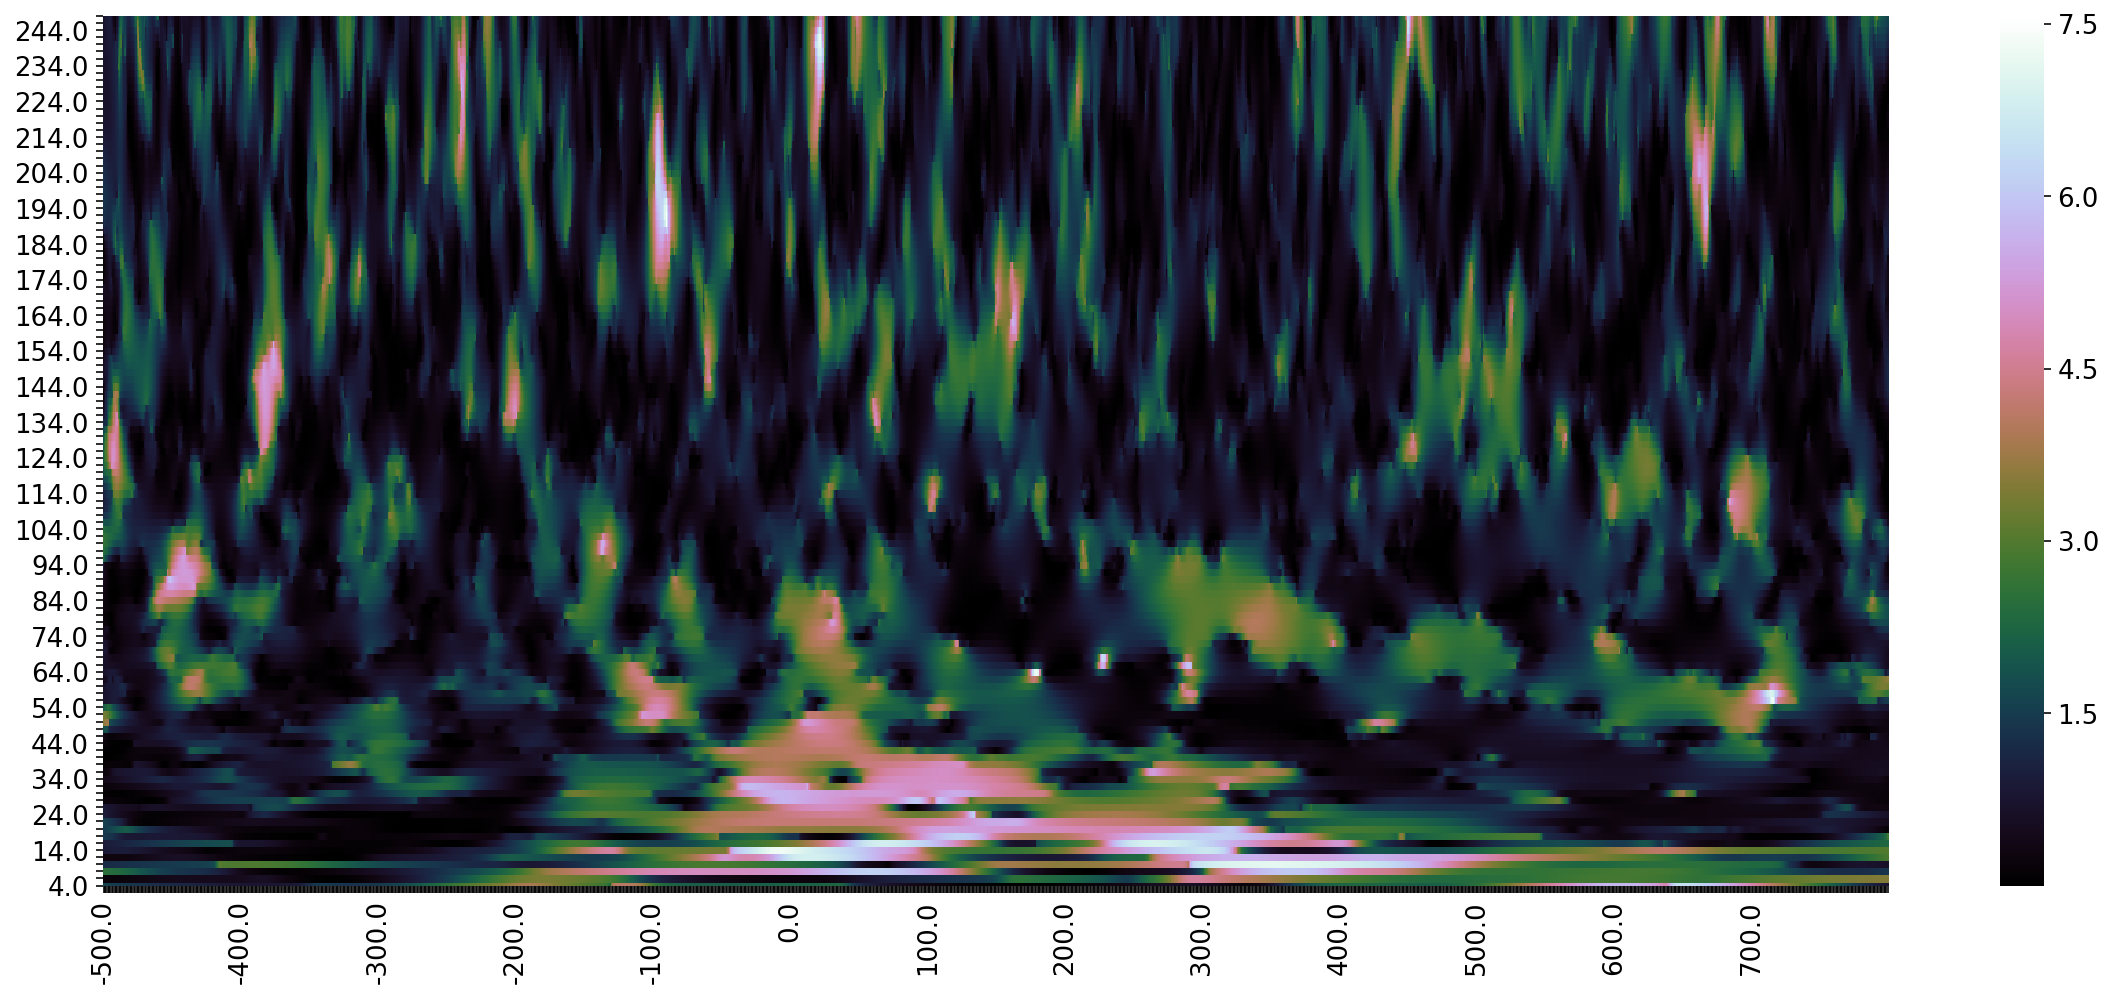

In [31]:
# plot_itc(test_itc_z[:,0,:], first_event_times, fc_lo, fc_hi, cmap= 'cubehelix')

# Plot the Behavior over the ITC

In [ ]:
# # Make the Figure

# ch = 17

# v_min = 0
# v_max = 2

# subsize = 25
# bigsize = 35
# ticksize = 17

# print(len(first_events))



# fig, ax_2d = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(30,15), dpi = 300)
# ax = [ax_inst for ax_inst in ax_2d.flat]

# fig, ax = plt.subplots(2, 1)


# # Make A Single ColorBar
# cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.76])

# # Plot First Behavior Raster
# plot_behavior_test(fill_events_context = fill_events_first, context_event_times = first_event_times, 
#                    context_events = first_events, ax=ax[0])
# ax[0].set_title(label="Start of Bout", fontsize=bigsize)
# ax[0].set_ylabel(ylabel='Bout Instances', fontsize=subsize)
# ax[0].tick_params(axis='both', which='major', labelsize=ticksize)

In [32]:
print(len(first_events))

10


In [67]:
def plot_behavior_test(fill_events_context, context_event_times, context_events, ax=None):
    # Setup the Colorbar
#     cmap2 = matplotlib.colors.ListedColormap(
#         ['black', 'red', 'orange', 'yellow', 'saddlebrown', 'blue', 'green', 'white', 'pink', 'purple'])
#     cmap2.set_over('cyan')
#     cmap2.set_under('green')
    
    cmap2 = matplotlib.colors.ListedColormap(
    ['#000000', '#B66DFF', '#db6e00', '#009292', '#924900', '#006DDB', '#B6DBFF', 'white', '#feb4d9', '#490092'])
    cmap2.set_over('cyan')
    cmap2.set_under('#B6DBFF')
    bounds = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N)

    # PlotBehavior Raster
    num_events = context_events.shape[0]
    max_len = fill_events_context.shape[0]
    bin_width = (max_len) / (num_events)
    y_labels = np.arange(0, num_events, 5, dtype=int)
    y_steps = np.linspace(0, y_labels[-1]*bin_width, len(y_labels), dtype=int)
    y_steps[1:] = y_steps[1:] - int(bin_width/2)

    if ax is None:
        plt.imshow(fill_events_context, cmap=cmap2, Norm=norm, aspect="auto")
        plt.yticks(ticks= y_steps[1:], labels= y_labels[1:])
        plt.ylim(0, max_len)

    else:
        ax.imshow(fill_events_context, cmap=cmap2, Norm=norm, aspect="auto")
        ax.set_yticks(y_steps[1:])
        ax.set_yticklabels(y_labels[1:])
        ax.set_ylim(0, max_len)
        ax.set_xticks([])

In [35]:
# Make the Figure

ch = 17

v_min = 0
v_max = 25

subsize = 25
bigsize = 35
ticksize = 17

print(len(first_events))
print(len(last_events))



fig, ax_2d = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(30,15), dpi = 300)
ax = [ax_inst for ax_inst in ax_2d.flat]

# Make A Single ColorBar
cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.76])

# Plot First Behavior Raster
plot_behavior_test(fill_events_context = fill_events_first, context_event_times = first_event_times, 
                   context_events = first_events, ax=ax[0])
ax[0].set_title(label="Start of Bout", fontsize=bigsize)
ax[0].set_ylabel(ylabel='Bout Instances', fontsize=subsize)
ax[0].tick_params(axis='both', which='major', labelsize=ticksize)


# Plot First LFP
# fig.subplots_adjust(right=0.95)
# plot_pretty_ersp(mean_first[:,ch,:], first_event_times,  vmin=v_min, vmax=v_max, ax = ax[2], cbar_ax = cbar_ax)

plot_itc(first_itc_z[:,ch,:], first_event_times, fc_lo, fc_hi, cmap= 'cubehelix',
         vmin=v_min, vmax=v_max, ax = ax[2], cbar_ax = cbar_ax)
ax[2].set_xlabel(xlabel='Time (ms)', fontsize=subsize)
ax[2].set_ylabel(ylabel='Frequency (Hz)', fontsize=subsize)
ax[2].tick_params(axis='both', which='major', labelsize=ticksize)


# Plot Last Behavior Raster
plot_behavior_test(fill_events_context = fill_events_last, context_event_times = last_event_times, 
                   context_events = last_events, ax=ax[1])
ax[1].set_title(label="End of Bout", fontsize=bigsize)
ax[1].set_ylabel(ylabel='Bout Instances', fontsize=subsize)
ax[1].tick_params(axis='both', which='major', labelsize=ticksize)


# Plot Last LFP
# fig.subplots_adjust(right=0.95)
# plot_pretty_ersp(mean_last[:,ch,:], last_event_times,  vmin=v_min, vmax=v_max, ax = ax[3], cbar_ax = cbar_ax)

plot_itc(last_itc_z[:,ch,:], last_event_times, fc_lo, fc_hi, cmap= 'cubehelix',
         vmin=v_min, vmax=v_max, ax = ax[3], cbar_ax = cbar_ax)
ax[3].set_xlabel(xlabel='Time (ms)', fontsize=subsize)
ax[3].set_ylabel(ylabel='Frequency (Hz)', fontsize=subsize)
ax[3].tick_params(axis='both', which='major', labelsize=ticksize)

# # Save the Figure
# figure_name = 'ITC' + bird_id + '_' + session + '_start_end_Chan-' +  str(ch+1) + '.png'
# figure_type_folder = FIGURES_DIR / 'ITC'

# # Check if Folder Path Exists
# if not figure_type_folder.exists():
#     figure_type_folder.mkdir(parents=True, exist_ok=True)

# figure_location = figure_type_folder / figure_name

# fig.savefig(figure_location, format='png')
# fig.savefig(figure_location, dpi=300, papertype=None, format='png')

27
27


In [60]:
np.asarray(test_y)

array([  2.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   4.,   4.,   4.,
         4.,   4.,   5.,   5.,   5.,   5.,   5.,   6.,   6.,   6.,   7.,
         7.,   7.,   8.,   8.,   8.,   9.,   9.,   9.,  10.,  10.,  11.,
        11.,  12.,  12.,  13.,  14.,  14.,  15.,  16.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  30.,
        31.,  33.,  34.,  36.,  37.,  39.,  41.,  43.,  45.,  47.,  49.,
        52.,  54.,  57.,  59.,  62.,  65.,  68.,  71.,  74.,  78.,  82.,
        85.,  90.,  94.,  98., 103., 108., 113., 118., 123., 129., 135.,
       142., 148., 155., 163., 170., 178., 187., 196., 205., 214., 224.,
       235.])

In [ ]:
# Make a index for the y axis
test_y = np.round(((fc_hi - fc_lo)/2) + fc_lo)

In [61]:
np.where(test_y==205.)

(array([96]),)

In [62]:


# [2., 10, 30, 50, 100, 200]

desired_labels = [2.0, 10.0, 50.0, 100.0, 200.0]

adjustment = [0, 30, 65, 80, 96]


In [63]:
# 65->50
test_y[65]=50
# 90_>80
test_y[80]=100
# 96->200
test_y[96]=200

In [64]:
for ind, label in enumerate(test_y):
        if ind in adjustment:
            print(label)
        else:
            pass

2.0
10.0
50.0
100.0
200.0


27
27


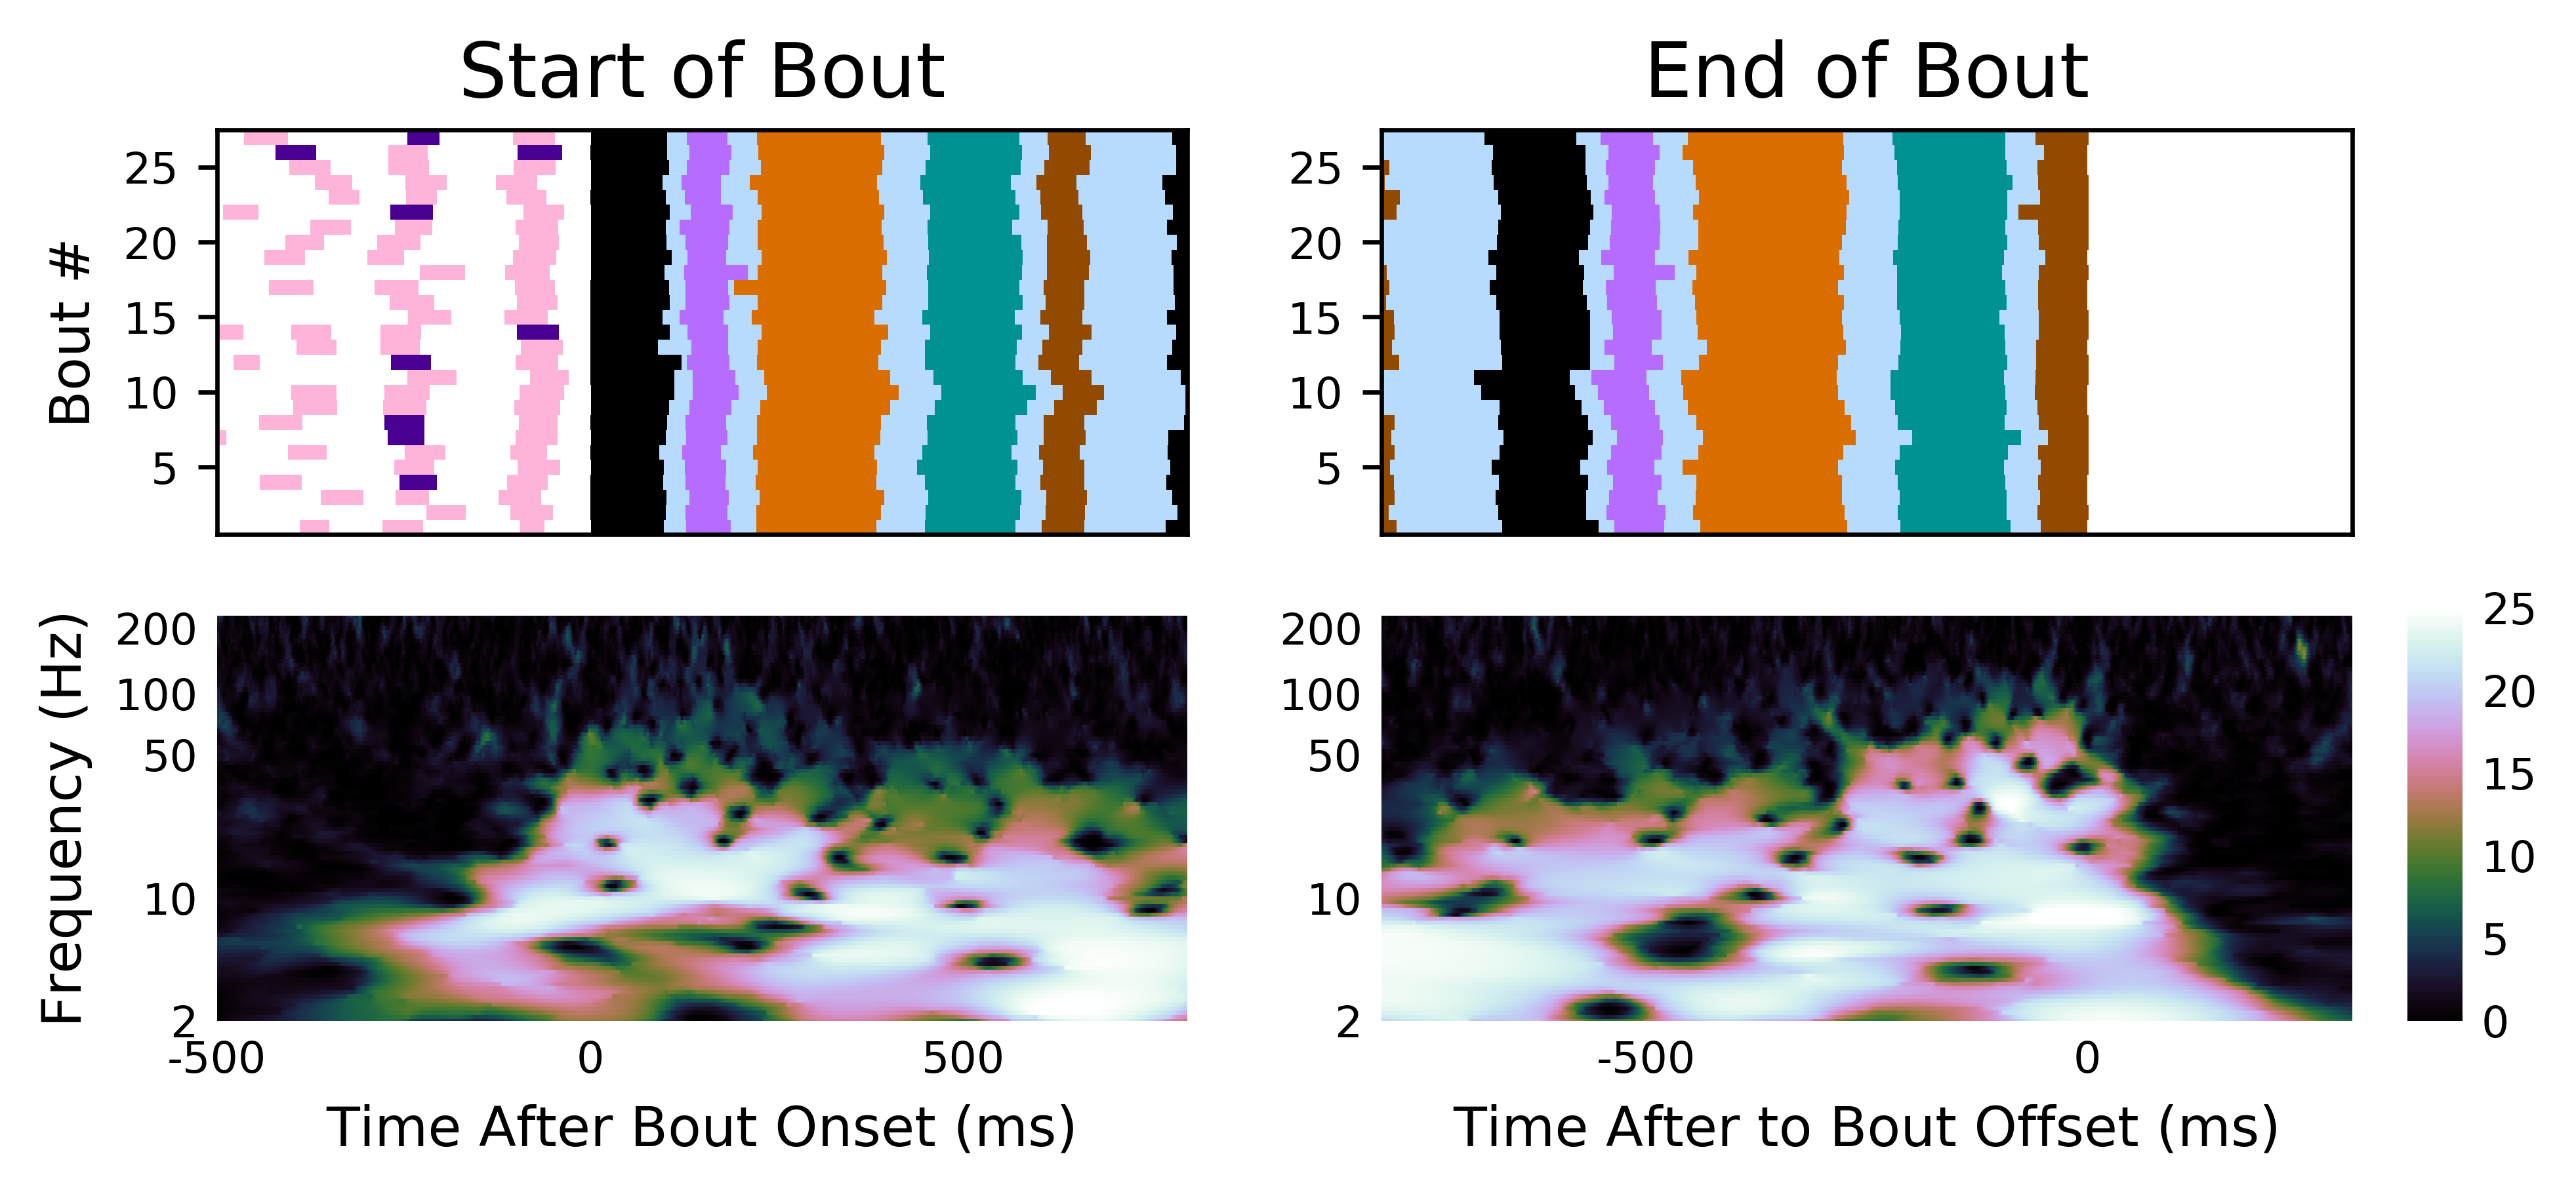

In [68]:
# Make the Figure

# Make the Figure

ch = 17

v_min = 0
v_max = 25

subsize = 10
bigsize = 14
ticksize = 8

print(len(first_events))
print(len(last_events))



fig, ax_2d = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(7, 3), dpi = 300)
ax = [ax_inst for ax_inst in ax_2d.flat]

# Make A Single ColorBar
cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.35])

# Plot First Behavior Raster
plot_behavior_test(fill_events_context = fill_events_first, context_event_times = first_event_times, 
                   context_events = first_events, ax=ax[0])
ax[0].set_title(label="Start of Bout", fontsize=bigsize)
ax[0].set_ylabel(ylabel='Bout #', fontsize=subsize)
ax[0].tick_params(axis='both', which='major', labelsize=ticksize)


# Plot First LFP
# fig.subplots_adjust(right=0.95)
# plot_pretty_ersp(mean_first[:,ch,:], first_event_times, fc_lo=fc_lo, fc_hi=fc_hi,  vmin=v_min, vmax=v_max, ax = ax[2], cbar_ax = cbar_ax)

sns.heatmap(first_itc_z[:,ch,:], xticklabels=first_event_times.astype(int), yticklabels= test_y.astype(int), 
                 ax=ax[2], cbar_ax=cbar_ax, vmin=v_min, vmax=v_max, cmap = 'cubehelix', cbar_kws={'ticks': [0.0, 1.0, 2.0] })

ax[2].invert_yaxis()

ax[2].set_xlabel(xlabel='Time After Bout Onset (ms)', fontsize=subsize)
ax[2].set_ylabel(ylabel='Frequency (Hz)', fontsize=subsize)
ax[2].tick_params(axis='both', which='major', labelsize=ticksize)

for ind, label in enumerate(ax[2].get_yticklabels()):
    if ind in adjustment:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
        
visible_xticks = []
visible_xtickslabels = []
for ind, label in enumerate(ax[2].get_xticklabels()):
    if ind % 500 == 0:
#             label.set_visible(True)
        visible_xticks.append(ind)
        visible_xtickslabels.append(label)
#         else:
#             label.set_visible(False)
ax[2].set_xticks(visible_xticks) 
ax[2].set_xticklabels(visible_xtickslabels, rotation=0)
ax[2].tick_params(axis='both', which='both',length=0)


# Plot Last Behavior Raster
plot_behavior_test(fill_events_context = fill_events_last, context_event_times = last_event_times, 
                   context_events = last_events, ax=ax[1])

ax[1].set_title(label="End of Bout", fontsize=bigsize)
# ax[1].set_ylabel(ylabel='Bout Instances', fontsize=subsize)
ax[1].tick_params(axis='both', which='major', labelsize=ticksize)


# Plot Last LFP
# fig.subplots_adjust(right=0.95)
# plot_pretty_ersp(mean_last[:,ch,:], last_event_times.astype(int), fc_lo=fc_lo, fc_hi=fc_hi, vmin=v_min, 
#                  vmax=v_max, ax = ax[3], cbar_ax = cbar_ax)

sns.heatmap(last_itc_z[:,ch,:], xticklabels=last_event_times.astype(int), yticklabels= test_y.astype(int), 
                 ax=ax[3], cbar_ax=cbar_ax, vmin=v_min, vmax=v_max, cmap = 'cubehelix', cbar_kws={'ticks': [0.0, 5.0, 10.0, 15.0,  20.0, 25.0] })

ax[3].invert_yaxis()


ax[3].set_xlabel(xlabel='Time After to Bout Offset (ms)', fontsize=subsize)
# ax[3].set_ylabel(ylabel='Frequency (Hz)', fontsize=subsize)
ax[3].tick_params(axis='both', which='major', labelsize=ticksize)

for ind, label in enumerate(ax[3].get_yticklabels()):
    if ind in adjustment:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
        
visible_xticks = []
visible_xtickslabels = []
for ind, label in enumerate(ax[3].get_xticklabels()):
    if ind in [300, 800]:
#             label.set_visible(True)
        visible_xticks.append(ind)
        visible_xtickslabels.append(label)
#         else:
#             label.set_visible(False)
ax[3].set_xticks(visible_xticks) 
ax[3].set_xticklabels(visible_xtickslabels, rotation=0)

ax[3].tick_params(axis='both', which='both',length=0)

# Update the Colorbar Axis
# cbar_ax.set_yticklabels(['0%', '100%', '200%'])
cbar_ax.tick_params(axis='y', which='both',length=0, labelsize =ticksize)


# Save the Figure
figure_name = 'ITC' + bird_id + '_' + session + '_start_end_Chan-' +  str(ch+1) + '_Final_cb.png'
figure_type_folder = FIGURES_DIR / 'ITC_Final'

# Check if Folder Path Exists
if not figure_type_folder.exists():
    figure_type_folder.mkdir(parents=True, exist_ok=True)

figure_location = figure_type_folder / figure_name

fig.savefig(figure_location, format='png')
fig.savefig(figure_location, dpi=300, papertype=None, format='png')

